## Lecture 14: Data carpentry with `tidyverse`

### STAT598z: Intro. to computing for statistics


***




### Vinayak Rao

#### Department of Statistics, Purdue University

In [1]:
options(repr.plot.width=5, repr.plot.height=3)

We will use a dataset of movies scraped off IMDB:
https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset
+ Available from the class website

In [2]:
movies_orig <- read.csv('~/RSRCH/DATA/movie_metadata.csv')
movies      <- movies_orig
# Can view this in RStudio using View(movies)
movies[1,]

color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,⋯,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
Color,James Cameron,723,178,0,855,Joel David Moore,1000,760505847,Action|Adventure|Fantasy|Sci-Fi,⋯,3054,English,USA,PG-13,2.37e+08,2009,936,7.9,1.78,33000


In [ ]:
unique(movies$director_name)

In [ ]:
unique(movies$director_name[movies$imdb_score>8.5])

In [ ]:
(movies$movie_title[movies$imdb_score>9])

In [3]:
library('tidyverse')
movies <- as_tibble(movies)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


Most functions that works with dataframes works with tibbles 
+ functions in `tidyverse` require tibbles
+ additionally, tibbles have some nice conveniences 

In [ ]:
my_rnd <- tibble(x=rnorm(10), y = x+1, z = x>0)
print(my_rnd) # tibbles also print a bit more nicely

### The 'pipe' operator `%>%`
`tidyuniverse` gets this from package `purrr` 
+ `magrittr` offers additional functionality

### A side point on infix functions
%func_name% is syntax for infix (rather than prefix) functions:

In [ ]:
'%plus%' <- function(x,y) x+y
    
1 %plus% 2; '%plus%'(3,4)

%>% pipes output of first function to first argument of the second

Can give more readable code. E.g. consider


In [ ]:
range(
      movies$actor_1_facebook_likes[
        order(
              movies$imdb_score, decreasing = T
             )
       ][1:10]
     )
# range(movies$actor_1_facebook_likes[
#   order(movies$imdb_score, decreasing = T)][1:10])

Have to parse code from inside to outside.

In [ ]:
movies$imdb_score %>% 
  order(decreasing = T) %>% 
  movies$actor_1_facebook_likes[.] %>% 
  .[1:10] %>%
  range

By default, output of function to left of `%>%` is  the first argument of the function to the right

Use `.` as placeholder if argument you are piping to is not the first

In [ ]:
4 %>% log(2) # log(4,2)

In [ ]:
4 %>% log(2,.) # log(2,4)

Can pipe to multiple arguments

In [ ]:
2 %>% log(.+6,.) # log(8,2)

Pipes in pipes are possible (but be careful)

In [ ]:
2 %>% log(.+6 %>% .^2 %>% print,.); log(38,2)

`tiyverse` gets `%>%` from the `purrr` package

The `magrittr` package provides more such functions.

E.g. the T-pipe `%T>%` passes the LHS onwards 
+ useful for functions like plot where output isn't important

In [ ]:
library(magrittr); rnorm(100) %T>% hist  %>% mean

http://www.fromthebottomoftheheap.net/2015/06/03/my-aversion-to-pipes/^

https://cran.r-project.org/web/packages/magrittr/vignettes/magrittr.html

https://www.r-statistics.com/2014/08/simpler-r-coding-with-pipes-the-present-and-future-of-the-magrittr-package/

Our next package from `tidyverse` is `dplyr`


+   `filter`: pick observations by values (rows)
+   `arrange`: reorder rows
+   `select`: pick variables (columns) by their names
+   `mutate`: create new variables from existing variables
+   `summarise`: summarise many values

The scope of each is determined by `group_by`

For a more thorough overview, look at *R for Data Science* (http://r4ds.had.co.nz/transform.html#datatransformation)

### The filter `filter()` function

Select observations/rows based on value

Cleaner alternative to indexing with logicals and `which`

In [ ]:
deniro <- filter(movies,actor_1_name == "Robert De Niro")
deniro[,c('imdb_score','movie_title')]

In [ ]:
deniro_good <- movies %>% 
                filter(actor_1_name == "Robert De Niro", 
                        imdb_score > 7)
deniro_good[,c('imdb_score','movie_title')]

Multiple argument are equivalent to logical AND (`&`):
```
 deniro_good <- filter(movies,actor_1_name == "Robert De Niro" & imdb_score > 7)
 ```
 Logical or's must be written using `|`

In [ ]:
dnr_pcn<-movies %>% 
         filter((actor_1_name=="Robert De Niro") |
                            (actor_1_name=="Al Pacino"), 
                        imdb_score > 7)
dnr_pcn[,c('actor_1_name','imdb_score','movie_title')]

###  The `select()` function

Unlike `filter()`, `select()` picks columns of a tibble

In [ ]:
select(deniro_good, movie_title, imdb_score)

In [ ]:
select(deniro_good, director_name:actor_2_name)[1:10,]

Can also use `-` to eliminate columns:

In [ ]:
select(deniro_good, -(director_name:actor_2_name))

Also includes convenience functions like `contains("actor")` and
`num_range("var",1:3)`

### The `arrange()` function

Orders rows in increasing order of any chosen column
* Additional columns can be provided to break ties
* `desc()` can be used to sort in decreasing order

Missing values always go at the end

In [ ]:
movies %>% arrange((imdb_score)) %>% 
   select(movie_title, imdb_score) %>% .[1:10,] 

In [ ]:
arrange(movies, imdb_score, gross) %>% 
  select(movie_title, imdb_score, gross) %>% .[1:10,] 

In [ ]:
tmp <- arrange(movies, desc(imdb_score), desc(gross))

### The `mutate()` function

Creates new columns at the end of current data.frame

In [ ]:
movies %>% filter(country== "USA") %>% 
     select(movie_title, imdb_score, gross, budget) %>%
     mutate(succ = gross/budget) %>% 
     arrange((succ)) %>% .[1:20,]

Why are some movies making such horrific losses?

`mutate` can refer to functions just created



In [ ]:
movies %>% filter(country == "USA") %>%
  select(movie_title, imdb_score, gross, budget) %>%
  mutate(succ = gross-budget, perc= 100*succ/budget) %>%
  distinct() %>% arrange((succ))

`distinct()` is a useful function to remove repeated rows
+ can provide column names as arguments for partial repetitions

`transmute()` is useful if we only care about the new column

###  `summarise()` and `group_by()`

Summarise collapses a dataframe to a single row:

In [ ]:
summarise(movies, score = mean(imdb_score))

Becomes very powerful in conjunction with `group_by()`

In [ ]:
top_dir <- movies %>% group_by(director_name) %>% 
        summarise(score = mean(imdb_score)) %>% 
        arrange(desc(score)) 
top_dir[1:15,]

`n()` is a convenient function to get number of elements

In [ ]:
top_dir <- movies %>% group_by(director_name) %>% 
        summarise(count=n(), score = mean(imdb_score)) %>% 
        arrange((score)) %>% 
        filter(count>=5)
top_dir

In [ ]:
yr_scr <- movies %>% group_by(title_year) %>% 
         summarise(count=n(), score = median(imdb_score), 
                              ymin = quantile(imdb_score,.1),
                              ymax=quantile(imdb_score,.9)) %>% 
         arrange(desc(score)) %>% filter(count>=5)
yr_scr

In [ ]:
ggplot(yr_scr , aes(x=title_year, y = score)) + 
    geom_line() + 
    geom_errorbar(aes(ymin=ymin,ymax=ymax))

Can have nested groupings (can revert with `ungroup()`)

In [ ]:
act_dir<-movies %>% group_by(actor_1_name,director_name) %>% 
        distinct(movie_title, .keep_all = T) %>%
        summarise(num = n(), scr = mean(gross-budget),
                  ttl = paste(movie_title, collapse=";")) %>% 
        arrange(desc(scr)) %>% filter(num>2) 
act_dir[1:20,] 

Let's try something more complicated:
+  Can we analyse scores/earnings across genres?

Things are actually a bit more complicated:

In [ ]:
levels(movies$genres)

In [6]:
gnr_type <- as.character(levels(movies_orig$genres)) %>% 
       strsplit('\\|') %>% #will see regular expressions later
       unlist %>% unique
gnr_type

[1] "Action"      "Adventure"   "Animation"   "Comedy"      "Crime"      
 [6] "Family"      "Fantasy"     "Drama"       "Thriller"    "Sci-Fi"     
[11] "Mystery"     "Romance"     "Biography"   "History"     "War"        
[16] "Music"       "Musical"     "Western"     "Horror"      "Documentary"
[21] "Sport"       "Short"       "Reality-TV"  "News"        "Film-Noir"  
[26] "Game-Show"

In [7]:
movies[,gnr_type] <- F
movies$genres <- as.character(movies$genres)
movies[29:54]

Action,Adventure,Animation,Comedy,Crime,Family,Fantasy,Drama,Thriller,Sci-Fi,⋯,Musical,Western,Horror,Documentary,Sport,Short,Reality-TV,News,Film-Noir,Game-Show
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,⋯,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [9]:
for(ii in 1:nrow(movies)) { # Will look at better approaches
  movies[ii,gnr_type] <- 
   gnr_type %in% strsplit(movies$genres[ii],"\\|")[[1]]
}

colnames(movies)[38] <- "Sci_fi"
colnames(movies)[51] <- "Reality_TV"
colnames(movies)[53] <- "Film_Noir"
colnames(movies)[54] <- "Game_Show"
gnr_type <- colnames(movies)[29:54]

In [10]:
rslt <- lm(paste("imdb_score ~", 
            (paste(gnr_type,collapse = '+'))), movies)
rslt


Call:
lm(formula = paste("imdb_score ~", (paste(gnr_type, collapse = "+"))), 
    data = movies)

Coefficients:
    (Intercept)       ActionTRUE    AdventureTRUE    AnimationTRUE  
        6.34887         -0.22870          0.17333          0.51413  
     ComedyTRUE        CrimeTRUE       FamilyTRUE      FantasyTRUE  
       -0.30408          0.19231         -0.32114          0.07070  
      DramaTRUE     ThrillerTRUE       Sci_fiTRUE      MysteryTRUE  
        0.50364         -0.23289          0.09841          0.14813  
    RomanceTRUE    BiographyTRUE      HistoryTRUE          WarTRUE  
       -0.07519          0.30742          0.08223          0.27006  
      MusicTRUE      MusicalTRUE      WesternTRUE       HorrorTRUE  
       -0.22144          0.07295          0.08353         -0.48746  
DocumentaryTRUE        SportTRUE        ShortTRUE   Reality_TVTRUE  
        0.76481         -0.02755          0.16924          0.12677  
       NewsTRUE    Film_NoirTRUE    Game_ShowTRUE  
       

In [11]:
movies$ntile <- ntile(movies$imdb_score,10)

`summarise_each` let's one summarize multiple columns easily

In [12]:
gnr_frac <- movies %>% group_by(ntile) %>% 
                       select(Action:Game_Show)%>% 
                       summarise_each(funs(mean))
gnr_frac

Adding missing grouping variables: `ntile`


ntile,Action,Adventure,Animation,Comedy,Crime,Family,Fantasy,Drama,Thriller,⋯,Musical,Western,Horror,Documentary,Sport,Short,Reality_TV,News,Film_Noir,Game_Show
1,0.2752475,0.1960396,0.04752475,0.4495050,0.1089109,0.15247525,0.15445545,0.2396040,0.3089109,⋯,0.02970297,0.01584158,0.24356436,0.007920792,0.02178218,0.000000000,0.001980198,0.000000000,0.000000000,0.001980198
2,0.2698413,0.1785714,0.04166667,0.5198413,0.1488095,0.14682540,0.15674603,0.2976190,0.2956349,⋯,0.01785714,0.01190476,0.19444444,0.013888889,0.02777778,0.001984127,0.000000000,0.000000000,0.000000000,0.000000000
3,0.3095238,0.2182540,0.04166667,0.4345238,0.1626984,0.11904762,0.13888889,0.4047619,0.3333333,⋯,0.02380952,0.01388889,0.15476190,0.001984127,0.02579365,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
4,0.3029703,0.1841584,0.03762376,0.4415842,0.2376238,0.10693069,0.12475248,0.4336634,0.3524752,⋯,0.01584158,0.01584158,0.14059406,0.003960396,0.03762376,0.001980198,0.000000000,0.000000000,0.000000000,0.000000000
5,0.2380952,0.1646825,0.03968254,0.3948413,0.2023810,0.08730159,0.09523810,0.5257937,0.3293651,⋯,0.02380952,0.02380952,0.08730159,0.003968254,0.03174603,0.001984127,0.000000000,0.000000000,0.000000000,0.000000000
6,0.2281746,0.1884921,0.05555556,0.3611111,0.2023810,0.10714286,0.13293651,0.5753968,0.3035714,⋯,0.02380952,0.02380952,0.07936508,0.015873016,0.03769841,0.000000000,0.001984127,0.000000000,0.000000000,0.000000000
7,0.2079208,0.1801980,0.06138614,0.3544554,0.1425743,0.10099010,0.10297030,0.6178218,0.2534653,⋯,0.03564356,0.01188119,0.07326733,0.025742574,0.04752475,0.001980198,0.000000000,0.000000000,0.000000000,0.000000000
8,0.1488095,0.1607143,0.04761905,0.3333333,0.1805556,0.08928571,0.08333333,0.6765873,0.2023810,⋯,0.02380952,0.02380952,0.04960317,0.033730159,0.05753968,0.001984127,0.000000000,0.001984127,0.003968254,0.000000000
9,0.1269841,0.1448413,0.03373016,0.2281746,0.1765873,0.07341270,0.10912698,0.6964286,0.2162698,⋯,0.03769841,0.01984127,0.05357143,0.073412698,0.03968254,0.000000000,0.000000000,0.001984127,0.003968254,0.000000000
10,0.1785714,0.2142857,0.07341270,0.1944444,0.2003968,0.09920635,0.11111111,0.6765873,0.2023810,⋯,0.02976190,0.03174603,0.04365079,0.059523810,0.03373016,0.000000000,0.000000000,0.001984127,0.003968254,0.000000000


Warning message:
“Transformation introduced infinite values in continuous y-axis”

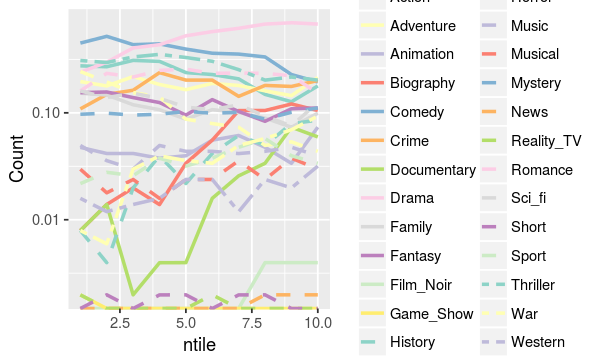

In [13]:
library('RColorBrewer')
gnr_frac %>% 
  gather('Genre','Count',Action:Game_Show) %>% ggplot() + 
  geom_line(aes(x=ntile,y=Count,color=Genre,linetype=Genre),
             size=1) + 
  scale_linetype_manual(values=c(rep("solid", 12),rep("dashed",11),
                                 rep("twodash",3))) +
  scale_color_manual(values=c(brewer.pal(12,"Set3"),
            brewer.pal(11,"Set3"), brewer.pal(3,"Set3"))) + 
  scale_y_log10()

`mutate_each` allows you to transform multiple columns

In [ ]:
gnr_frac %>% mutate_each(funs(./sum(.)),Action:Game_Show) 

### Generating tidy data

The `gather' function, allows you to combine multiple columns into 2 coloumns.
+ turns wide data into tall data

Tall data is useful for  e.g. `ggplot`

In [14]:
state_info <- as_tibble(state.x77)
print(state_info[1:10,])

# A tibble: 10 × 8
   Population Income Illiteracy `Life Exp` Murder `HS Grad` Frost   Area
        <dbl>  <dbl>      <dbl>      <dbl>  <dbl>     <dbl> <dbl>  <dbl>
1        3615   3624        2.1      69.05   15.1      41.3    20  50708
2         365   6315        1.5      69.31   11.3      66.7   152 566432
3        2212   4530        1.8      70.55    7.8      58.1    15 113417
4        2110   3378        1.9      70.66   10.1      39.9    65  51945
5       21198   5114        1.1      71.71   10.3      62.6    20 156361
6        2541   4884        0.7      72.06    6.8      63.9   166 103766
7        3100   5348        1.1      72.48    3.1      56.0   139   4862
8         579   4809        0.9      70.06    6.2      54.6   103   1982
9        8277   4815        1.3      70.66   10.7      52.6    11  54090
10       4931   4091        2.0      68.54   13.9      40.6    60  58073


`geom_smooth()` using method = 'loess'


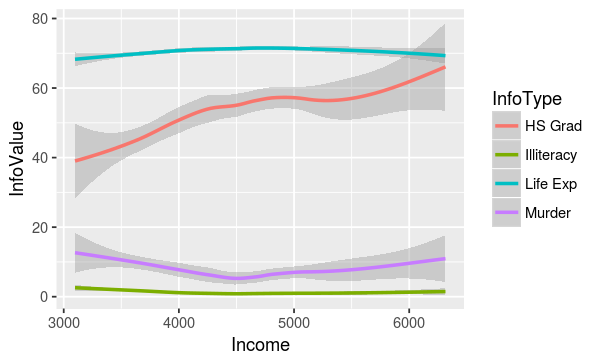

In [15]:
state_tall <- state_info %>% 
  gather(Illiteracy:`HS Grad`, key='InfoType',value='InfoValue')
  ggplot(state_tall) + 
   geom_smooth(aes(x=Income, y=InfoValue,color=InfoType))

`geom_smooth()` using method = 'gam'
Warning message:
“Removed 876 rows containing non-finite values (stat_smooth).”

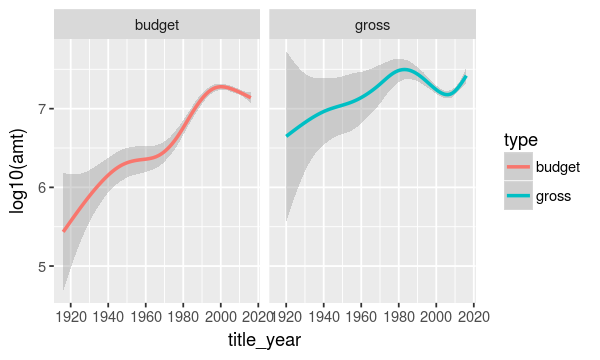

In [16]:
movies %>% filter(country=="USA") %>% 
     select(title_year, budget, gross)  %>% 
    gather(budget,gross, key = 'type', value='amt') %>% 
      ggplot + geom_smooth(aes(x=title_year,y=log10(amt), 
                               group=type, color=type)) +
      facet_wrap(~type)

`geom_smooth()` using method = 'gam'
Warning message:
“Removed 694 rows containing non-finite values (stat_smooth).”

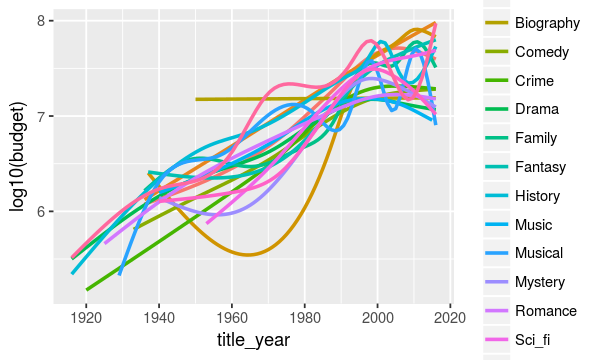

In [18]:
movies %>% filter(country=="USA") %>% 
    select(title_year, budget, Action:Musical)  %>% 
    gather(Action:Musical, key = 'type', value='amt') %>% 
    filter(amt==TRUE) %>%  
      ggplot + geom_smooth(aes(x=title_year,y=log10(budget), 
                               group=type, color=type),se=F)

`spread()` does the opposite
+ turns a tall  data.frame into a wide one

Wide data is useful for e.g. `lm`

In [19]:
spread(state_tall, key = InfoType, value=InfoValue)

Population,Income,Frost,Area,HS Grad,Illiteracy,Life Exp,Murder
365,6315,152,566432,66.7,1.5,69.31,11.3
376,4566,173,97203,62.9,0.6,70.29,6.9
472,3907,168,9267,57.1,0.6,71.64,5.5
579,4809,103,1982,54.6,0.9,70.06,6.2
590,5149,188,109889,65.2,0.5,69.03,11.5
637,5087,186,69273,50.3,0.8,72.78,1.4
681,4167,172,75955,53.3,0.5,72.08,1.7
746,4347,155,145587,59.2,0.6,70.56,5.0
812,4281,174,9027,57.6,0.7,71.23,3.3
813,4119,126,82677,59.5,0.6,71.87,5.3


In [20]:
stdnt <- tibble(
  name      = rep(c("Alice", "Bob"), each=4),
  year      = c(2015, 2015, 2016, 2016, 2015, 2015, 2016, 2016),
  semester  = c("Spring","Fall","Spring","Fall", "Spring","Fall","Spring","Fall"),
  gpa = c(3.2, 3.9, 3.1, 3.6, 3.1, 3.9, 3.3, 3.3)
  )
stdnt

name,year,semester,gpa
Alice,2015,Spring,3.2
Alice,2015,Fall,3.9
Alice,2016,Spring,3.1
Alice,2016,Fall,3.6
Bob,2015,Spring,3.1
Bob,2015,Fall,3.9
Bob,2016,Spring,3.3
Bob,2016,Fall,3.3


In [21]:
stdnt %>% spread(key=semester, value=gpa)

name,year,Fall,Spring
Alice,2015,3.9,3.2
Alice,2016,3.6,3.1
Bob,2015,3.9,3.1
Bob,2016,3.3,3.3


What if there are missing/extra values?

`melt()` and `dcast()` from package `reshape` are slightly more powerful
+ however, `tidyr` with `splyr` should meet all your needs

Another useful pair of functions in `separate()` and `unite()`

In [22]:
tmp <- movies %>% separate(director_name,c("First","Last"), 
                           sep=" ")

Warning message:
“Too many values at 398 locations: 53, 140, 141, 169, 180, 198, 225, 234, 242, 268, 306, 334, 349, 380, 381, 384, 388, 395, 402, 431, ...”Warning message:
“Too few values at 118 locations: 45, 178, 227, 261, 314, 361, 405, 460, 480, 538, 544, 594, 646, 675, 685, 686, 758, 817, 827, 834, ...”

Can control what to do with missing/extra elements:

tmp <- movies %>% separate(director_name,c("First","Last"), sep=" ", extra="merge", fill="left")

Regular expressions will allow more expressivity

`unite()` does the opposite

In [ ]:
tmp <- unite(stdnt, yr_sm, year, semester)

In [ ]:
spread(tmp, key=yr_sm, value=gpa)